In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 200

# Import the data
nyc_registry = pd.read_csv('../dogdata/NYC_Dog_Licensing_Dataset_2015-edit.csv')
coren = pd.read_csv('../dogdata/coren-edit.csv')
# nyc_census = pd.read_csv('../censusdata/ACS_16_1YR_S0201_with_ann-edit.csv') # use 2016 data
edmonton_registry = pd.read_csv('../dogdata/Edmonton_Pet_Licenses_by_Neighbourhood_2018-edit.csv')
adelaide_registry = pd.read_csv('../dogdata/Dog_Registrations_Adelaide_2016-edit.csv')
seattle_registry = pd.read_csv('../dogdata/Seattle_Pet_Licenses-2018-edit2.csv')
wiki = pd.read_csv('../dogdata/wiki-edit.csv')
turcsan = pd.read_csv('../dogdata/turcsan.csv')

# List of attributes
lst = ['Bold', 'Calm', 'Obedient','Sociable', 'Trainable']
borough = ['Bronx','Brooklyn','Manhattan','Queens','Staten Island']
# Pare down the Coren data
coren = coren[['Breed', 'Obedient']]
# Combine the Coren and Turcsan datasets
attrib = coren.set_index('Breed').join(turcsan.set_index('Breed'), how='outer')


def describe(df, categ, filename=None, display=True):
    """Show the mean and standard deviation of the data and optionally plot. Optionally save a file of the plot.
    
    Arguments:
        df {DataFrame} -- DataFrame to describe
        categ {str} -- Display category
    
    Keyword Arguments:
        filename {str} -- Name of file to save to (default: {None})
        display {bool} -- Whether or not to display a plot (default: {True})
    """
    print('\n'+categ+' Mean')
    attrib_mean = df[lst].mean()
    print(attrib_mean.round(decimals=2))
    print('\n'+categ+' Standard Deviation')
    print(attrib[lst].std().round(decimals=2))

    plt.title(categ+' Overall Attributes')
    plt.bar(attrib_mean.index, attrib_mean.values)
    plt.ylim([0,0.75])
    if filename is not None:
        plt.savefig('../plots/'+filename)
    if display:
        plt.show()

def describe_breeds(save=False):
    '''Show the intersection of different breeds of dogs according to which dataset they come from. For example, Dogue de Bordeaux is in the Turcsan set but not in the Wiki scraped set.

    Returns:
        None
    '''
    wiki_breeds = set(wiki['Breed'].tolist())
    coren_breeds = set(coren['Breed'].tolist())
    turcsan_breeds = set(turcsan['Breed'].tolist())

    print('\nIntersection, Wiki and Turcsan')
    print(wiki_breeds & turcsan_breeds)
    print('\nIntersection, Wiki and Coren')
    print(wiki_breeds & coren_breeds)
    print('\nDifference, Wiki - Turcsan')
    print(wiki_breeds - turcsan_breeds)
    print('\nDifference, Turcsan - Wiki')
    print(turcsan_breeds - wiki_breeds)
    print('\nDifference, Wiki - Coren')
    print(wiki_breeds - coren_breeds)
    print('\nDifference, Coren - Wiki')
    print(coren_breeds - wiki_breeds)

def plot_by_attrib(df, categ,label, filename=None, display=True):
    """Plot a graph by the attributes provided.
    
    Arguments:
        df {DataFrame} -- DF to plot
        categ {list} -- Categories to plot
        label {str} -- Label for what the data is describing
    
    Keyword Arguments:
        filename {str} -- Name of the file to optionally save (default: {None})
        display {bool} -- Whether or not to display the plot (default: {True})
    """
    fig, ax = plt.subplots()
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    for item in categ:
        ax.plot(df.index, df[item])

    plt.gcf().subplots_adjust(bottom=0.3, right=.75)
    plt.legend(loc=(1.04,0.6))
    plt.title('Scores by '+ label)
    ax.set_ylabel('Score')
    ax.set_xlabel(label)
    if filename is not None:
        plt.savefig('../plots/'+filename)
    if display:
        plt.show()


def splitDataFrameList(df,target_column,separator):
    """Thanks to James Allen, https://gist.github.com/jlln/338b4b0b55bd6984f883
    
    Arguments:
        df {DataFrame} -- DataFrame to split,
        target_column {string} -- The column containing the values to split
        separator {str} -- The symbol used to perform the split
    
    Returns:
        DataFrame -- A dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    """
    def splitListToRows(row,row_accumulator,target_column,separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)
    new_rows = []
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,separator))
    new_df = pd.DataFrame(new_rows)
    return new_df

In [2]:
print('New York total records: ',nyc_registry.shape[0])
print('Seattle total records:  ',seattle_registry.shape[0])
print('Edmonton total records: ',edmonton_registry.shape[0])
print('Adelaide total records: ',adelaide_registry.shape[0])

New York total records:  121950
Seattle total records:   18227
Edmonton total records:  59266
Adelaide total records:  16075


In [23]:
ny_pop = 8582000
seattle_pop = 3870000
edmonton_pop = 966000
adelaide_pop = 1340000

print('New York ownership/reporting percentage: ',round(100*nyc_registry.shape[0]/ny_pop,3))
print('Seattle ownership/reporting percentage: ',round(100*seattle_registry.shape[0]/seattle_pop,3))
print('Edmonton ownership/reporting percentage: ',round(100*edmonton_registry.shape[0]/edmonton_pop,3))
print('Adelaide ownership/reporting percentage: ',round(100*adelaide_registry.shape[0]/adelaide_pop,3))


New York ownership/reporting percentage:  1.178
Seattle ownership/reporting percentage:  0.471
Edmonton ownership/reporting percentage:  6.135
Adelaide ownership/reporting percentage:  1.2


In [22]:
print('Correlation coefficients')
attrib.corr()

Correlation coefficients


,Obedient,Calm,Trainable,Sociable,Bold
Obedient,1.000000,-0.249117,0.354953,-0.217504,-0.231250
Calm,-0.249117,1.000000,-0.596697,0.864370,0.753806
Trainable,0.354953,-0.596697,1.000000,-0.331093,-0.409075
Sociable,-0.217504,0.864370,-0.331093,1.000000,0.815936
Bold,-0.231250,0.753806,-0.409075,0.815936,1.000000


In [5]:
# Show which dogs are in each dataset.
describe_breeds()


Intersection, Wiki and Turcsan
{'French Bulldog', 'German Shorthaired Pointer', 'Chihuahua', 'Gordon Setter', 'Saint Bernard', 'Bulldog', 'Coton de Tulear', 'Soft-Coated Wheaten Terrier', 'Boxer', 'Australian Shepherd', 'Whippet', 'English Setter', 'Siberian Husky', 'Shar Pei', 'Golden Retriever', 'Giant Schnauzer', 'Bearded Collie', 'Airedale Terrier', 'Bernese Mountain Dog', 'Greater Swiss Mountain Dog', 'Maltese', 'Irish Setter', 'Shih Tzu', 'Staffordshire Bull Terrier', 'Shiba Inu', 'Weimaraner', 'Rhodesian Ridgeback', 'Brittany', 'Miniature Poodle', 'Irish Terrier', 'Irish Wolfhound', 'Great Dane', 'Dachshund', 'Border Terrier', 'Flat-Coated Retriever', 'American Staffordshire Terrier', 'Pekingese', 'Jack Russell Terrier', 'Cairn Terrier', 'Border Collie', 'Bull Terrier', 'Cavalier King Charles Spaniel', 'Polish Lowland Sheepdog', 'Rottweiler', 'Standard Schnauzer', 'Beauceron', 'Yorkshire Terrier', 'Lhasa Apso', 'Pointer', 'Alaskan Malamute', 'Doberman Pinscher', 'Pug', 'Ibizan 


AKC Mean
              Obedient  Calm  Trainable  Sociable  Bold
AKC                                                    
Herding           0.77  0.30       0.85      0.45  0.30
Hound             0.40  0.50       0.67      0.58  0.33
Non-Sporting      0.51  0.44       0.67      0.44  0.22
Sporting          0.73  0.67       0.62      0.67  0.62
Terrier           0.51  0.30       0.75      0.30  0.35
Toy               0.40  0.62       0.25      0.56  0.69
Working           0.60  0.45       0.73      0.41  0.36

AKC Standard Deviation
              Obedient  Calm  Trainable  Sociable  Bold
AKC                                                    
Herding           0.20  0.48       0.24      0.44  0.48
Hound             0.21  0.55       0.41      0.38  0.52
Non-Sporting      0.26  0.53       0.43      0.39  0.44
Sporting          0.15  0.49       0.38      0.44  0.48
Terrier           0.17  0.48       0.35      0.48  0.47
Toy               0.23  0.52       0.27      0.50  0.37
Working       

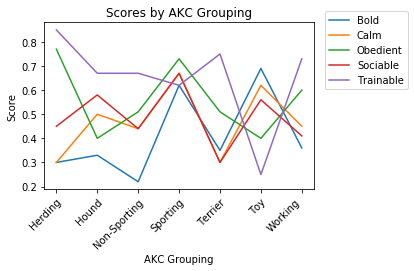

In [6]:
# Canine attributes by AKC groupings
wiki_akc = wiki[['Breed', 'AKC']]
akc_groups_attrib = wiki_akc.set_index('Breed').join(attrib, how='left')
print('\nAKC Mean')
akc = akc_groups_attrib.groupby('AKC').mean().round(decimals=2)
pprint(akc)
print('\nAKC Standard Deviation')
akc_std = akc_groups_attrib.groupby('AKC').std().round(decimals=2)
pprint(akc_std)
print('\nAKC Count')
akc_count = akc_groups_attrib.groupby('AKC').count()
pprint(akc_count)

# Plot the AKC grouping data
plot_by_attrib(akc, lst, 'AKC Grouping')

In [7]:
# Strip out NYC dirty values
nyc_registry['Borough'] = nyc_registry['Borough'].map(lambda x: None if x not in {'Brooklyn', 'Bronx', 'Staten Island', 'Manhattan', 'Queens'} else x)
nyc_registry['BreedName'] = nyc_registry['BreedName'].map(lambda x: None if x == 'Unknown' else x)
nyc_registry.dropna(inplace=True)

# Display breed attributes by NYC borough
display = False
norm=False # Do not normalize
nyc_attrib = nyc_registry.set_index('BreedName').join(attrib, how='left')
nyc_attrib = nyc_attrib[['Borough','Calm', 'Trainable', 'Sociable', 'Bold', 'Obedient']]
nyc_attrib_g = nyc_attrib.groupby('Borough')
print('\nNYC Mean:')
nyc_attrib_g_mean = nyc_attrib_g.mean()
pprint(nyc_attrib_g_mean.round(decimals=2))
print('\nNYC Standard Deviation:')
pprint(nyc_attrib_g.std().round(decimals=2))
print('\nNYC Count:')
pprint(nyc_attrib_g.count())
if display:
    plot_by_attrib(nyc_attrib_g_mean, lst, 'NYC Borough')

nyc_breeds = nyc_registry[['Borough', 'BreedName']]
print('\nTop NYC Dogs Count')
pprint(nyc_breeds['BreedName'].value_counts().nlargest(5))
nyc_breeds_grp = nyc_breeds.groupby('Borough')
print('\nTop Dogs By Borough')
for b in borough:
    print('\n'+b)
    print(nyc_breeds_grp.get_group(b)['BreedName'].value_counts(normalize=norm).head(5))


NYC Mean:
               Calm  Trainable  Sociable  Bold  Obedient
Borough                                                 
Bronx          0.40       0.35      0.40  0.60      0.48
Brooklyn       0.45       0.43      0.46  0.60      0.50
Manhattan      0.51       0.47      0.52  0.62      0.53
Queens         0.46       0.41      0.47  0.62      0.50
Staten Island  0.51       0.44      0.51  0.64      0.53

NYC Standard Deviation:
               Calm  Trainable  Sociable  Bold  Obedient
Borough                                                 
Bronx          0.49       0.36      0.48  0.36      0.28
Brooklyn       0.50       0.37      0.49  0.40      0.28
Manhattan      0.50       0.36      0.49  0.41      0.27
Queens         0.50       0.36      0.48  0.39      0.29
Staten Island  0.50       0.35      0.49  0.40      0.30

NYC Count:
                Calm  Trainable  Sociable   Bold  Obedient
Borough                                                   
Bronx           5827       5827     

In [8]:
# Perform Chi-Square analysis on NYC data
chi2_breed = ['Yorkshire Terrier', 'Shih Tzu','Chihuahua', 'Maltese', 'Labrador Retriever']
chi2_breed_com = itertools.combinations(chi2_breed, 2)
nyc_breeds_5 = nyc_registry[nyc_registry['BreedName'].isin(chi2_breed)] #top 5 breeds overall
for i in chi2_breed_com:
    print('\n',i)
    nyc_breeds_2 = nyc_registry[nyc_registry['BreedName'].isin(i)]
    contingency_table = pd.crosstab(nyc_breeds_2['BreedName'], nyc_breeds_2['Borough'])
    nyc_chi2 = stats.chi2_contingency(contingency_table)
    print('Test statistic: {}'.format(nyc_chi2[0].round(2)))
    print('P-value: {}'.format(nyc_chi2[1]))


 ('Yorkshire Terrier', 'Shih Tzu')
Test statistic: 6.0
P-value: 0.19935815394309653

 ('Yorkshire Terrier', 'Chihuahua')
Test statistic: 98.16
P-value: 2.429327716068869e-20

 ('Yorkshire Terrier', 'Maltese')
Test statistic: 72.38
P-value: 7.147745625233244e-15

 ('Yorkshire Terrier', 'Labrador Retriever')
Test statistic: 409.12
P-value: 2.980385866171689e-87

 ('Shih Tzu', 'Chihuahua')
Test statistic: 133.21
P-value: 7.994705402523028e-28

 ('Shih Tzu', 'Maltese')
Test statistic: 76.64
P-value: 8.981695413046296e-16

 ('Shih Tzu', 'Labrador Retriever')
Test statistic: 411.94
P-value: 7.309724499346304e-88

 ('Chihuahua', 'Maltese')
Test statistic: 147.63
P-value: 6.557578045686694e-31

 ('Chihuahua', 'Labrador Retriever')
Test statistic: 343.14
P-value: 5.304888286870627e-73

 ('Maltese', 'Labrador Retriever')
Test statistic: 289.52
P-value: 1.9691645730782012e-61


In [10]:
seattle_attrib_pri = seattle_registry.set_index('Primary Breed').join(attrib, how='left')
seattle_attrib_sec = seattle_registry.set_index('Secondary Breed').join(attrib, how='left')

seattle_attrib_pri.set_index('License Number', inplace=True)
seattle_attrib_sec.set_index('License Number', inplace=True)

seattle_attrib = seattle_attrib_pri.join(seattle_attrib_sec.drop(columns=['Animal\'s Name','License Issue Date','Species','ZIP Code']),\
                                         how='left', rsuffix='_sec')

# Didn't do Obedient
seattle_attrib['Bold2'] = np.where(pd.isnull(seattle_attrib['Bold_sec']), seattle_attrib['Bold'], \
                                  (seattle_attrib['Bold_sec']))
seattle_attrib['Bold'] = (seattle_attrib['Bold2'] + seattle_attrib['Bold'])/2
seattle_attrib['Calm2'] = np.where(pd.isnull(seattle_attrib['Calm_sec']), seattle_attrib['Calm'], \
                                  (seattle_attrib['Calm_sec']))
seattle_attrib['Calm'] = (seattle_attrib['Calm2'] + seattle_attrib['Calm'])/2
seattle_attrib['Trainable2'] = np.where(pd.isnull(seattle_attrib['Trainable_sec']), seattle_attrib['Trainable'], \
                                  (seattle_attrib['Trainable_sec']))
seattle_attrib['Trainable'] = (seattle_attrib['Trainable2'] + seattle_attrib['Trainable'])/2
seattle_attrib['Sociable2'] = np.where(pd.isnull(seattle_attrib['Sociable_sec']), seattle_attrib['Sociable'], \
                                  (seattle_attrib['Sociable_sec']))
seattle_attrib['Sociable'] = (seattle_attrib['Sociable2'] + seattle_attrib['Sociable'])/2


seattle_attrib.drop(columns=['Bold_sec','Bold2','Sociable_sec','Sociable2','Calm2','Calm_sec','Trainable2'\
                            ,'Trainable_sec'], inplace=True)

seattle_attrib

,License Issue Date,Animal's Name,Species,Secondary Breed,ZIP Code,Obedient,Calm,Trainable,Sociable,Bold,Primary Breed,Obedient_sec
License Number,,,,,,,,,,,,
112269,April 04 2018,Monticello,Dog,NaN,98117,0.50,NaN,NaN,NaN,NaN,Bichon Frise,NaN
120876,May 22 2018,NaN,Dog,NaN,98115,NaN,0.0,1.00,0.50,0.00,Miniature Poodle,NaN
125547,March 30 2018,Chula,Dog,Miniature Poodle,98115,NaN,0.5,0.75,0.75,0.50,American Cocker Spaniel,NaN
125881,March 20 2018,Kahlua,Dog,NaN,98133,0.70,0.0,1.00,0.00,0.00,Miniature Pinscher,NaN
126055,June 01 2018,Oberon,Dog,NaN,98117,0.95,1.0,0.50,1.00,1.00,Labrador Retriever,NaN
126404,March 21 2018,Lucky,Dog,NaN,98104,0.70,NaN,NaN,NaN,NaN,Affenpinscher,NaN
126645,March 19 2018,Mr Bean,Dog,NaN,98103,0.85,1.0,0.50,1.00,1.00,Miniature Schnauzer,NaN
126680,April 12 2018,Rafaela,Dog,NaN,98199,0.50,0.0,1.00,0.00,0.00,Dachshund,NaN
126835,March 27 2018,Buck Russell,Dog,NaN,98116,0.50,0.0,1.00,0.00,0.00,Jack Russell Terrier,NaN


# Perform hypothesis tests on data

LOOK AT HISTOGRAMS OF DATA OF EXTREME RESULTS IE E-122

In [11]:
print('Within NYC')
print('Note: due to Bonferroni correction, p-value must be lower than .00625\n')
print('Alternative Hypothesis: dogs from Staten Island are bolder than other dogs in New York.')

non_staten = nyc_attrib[nyc_attrib['Borough'].isin(['Manhattan', 'Queens', 'Bronx', 'Brooklyn'])]
non_staten.dropna(inplace=True)
non_staten_bold = non_staten['Bold']
staten = nyc_attrib[nyc_attrib['Borough'] == 'Staten Island']
staten.dropna(inplace=True)
staten_bold = staten['Bold']
print(stats.ttest_ind(staten_bold, non_staten_bold, equal_var = False))

print('Alternative Hypothesis: dogs from Staten Island are calmer than other dogs in New York.')
non_staten_calm = non_staten['Calm']
staten_calm = staten['Calm']
print(stats.ttest_ind(staten_calm, non_staten_calm, equal_var = False))

print('Alternative Hypothesis: dogs from the Bronx and Queens are less trainable than other dogs in New York.')
non_bronxq = nyc_attrib[nyc_attrib['Borough'].isin(['Manhattan', 'Staten Island', 'Brooklyn'])]
non_bronxq.dropna(inplace=True)
non_bronxq_trainable = non_bronxq['Trainable']
bronxq = nyc_attrib[nyc_attrib['Borough'].isin(['Queens', 'Bronx'])]
bronxq.dropna(inplace=True)
bronxq_trainable = bronxq['Trainable']
print(stats.ttest_ind(bronxq_trainable, non_bronxq_trainable, equal_var = False))

print('Alternative Hypothesis: dogs from the Bronx and Queens are less sociable than other dogs in New York.')
non_bronxq_sociable = non_bronxq['Sociable']
bronxq_sociable = bronxq['Sociable']
print(stats.ttest_ind(non_bronxq_sociable, bronxq_sociable, equal_var = False))

print('Null Hypothesis: The average boldness of dogs in Brooklyn is the same as the average boldness for other New York dogs.')
print('Alternative Hypothesis: The average boldness of Brooklyn and other New York dogs is different.')
non_brooklyn = nyc_attrib[nyc_attrib['Borough'].isin(['Manhattan', 'Queens', 'Bronx', 'Staten Island'])]
non_brooklyn.dropna(inplace=True)
non_brooklyn_bold = non_brooklyn['Bold']
brooklyn = nyc_attrib[nyc_attrib['Borough'] == 'Brooklyn']
brooklyn.dropna(inplace=True)
brooklyn_bold = staten['Bold']
print(stats.ttest_ind(brooklyn_bold, non_brooklyn_bold, equal_var = False))

print('Null Hypothesis: The average trainability of dogs in Brooklyn is the same as the average trainability for other New York dogs.')
print('Alternative Hypothesis: The average trainability of Brooklyn and other New York dogs is different.')
non_brooklyn_trainable = non_brooklyn['Trainable']
brooklyn_trainable = brooklyn['Trainable']
print(stats.ttest_ind(non_brooklyn_trainable, brooklyn_trainable, equal_var = False))

print('Null Hypothesis: The average calmness of dogs in Brooklyn is the same as the average calmness for other New York dogs.')
print('Alternative Hypothesis: The average calmness of Brooklyn and other New York dogs is different.')
non_brooklyn_calm = non_brooklyn['Calm']
brooklyn_calm = brooklyn['Calm']
print(stats.ttest_ind(non_brooklyn_calm, brooklyn_calm, equal_var = False))

print('Null Hypothesis: The average sociability of dogs in Brooklyn is the same as the average sociability for other New York dogs.')
print('Alternative Hypothesis: The average sociability of Brooklyn and other New York dogs is different.')
non_brooklyn_sociable = non_brooklyn['Sociable']
brooklyn_sociable = brooklyn['Sociable']
print(stats.ttest_ind(non_brooklyn_sociable, brooklyn_sociable, equal_var = False))

print('\nNYC vs. Seattle')
print('Null Hypothesis: The average boldness of dogs in NYC is the same as the boldness for Seattle dogs.')
print('Alternative Hypothesis: The average boldness of NYC and Seattle dogs is different.')
seattle_bold = seattle_attrib['Bold']
seattle_bold.dropna(inplace=True)
nyc_bold = nyc_attrib['Bold']
nyc_bold.dropna(inplace=True)
print(stats.ttest_ind(nyc_bold, seattle_bold, equal_var = False))

print('Alternative Hypothesis: Seattle dogs are more trainable than NYC dogs.')
seattle_trainable = seattle_attrib['Trainable']
seattle_trainable.dropna(inplace=True)
nyc_trainable = nyc_attrib['Trainable']
nyc_trainable.dropna(inplace=True)
print(stats.ttest_ind(nyc_trainable, seattle_trainable, equal_var = False))

print('Alternative Hypothesis: Seattle dogs are more sociable than NYC dogs.')
seattle_sociable = seattle_attrib['Sociable']
seattle_sociable.dropna(inplace=True)
nyc_sociable = nyc_attrib['Sociable']
nyc_sociable.dropna(inplace=True)
print(stats.ttest_ind(nyc_sociable, seattle_sociable, equal_var = False))

print('\nNYC vs. the Adelaide and Edmonton')
print('Alternative Hypothesis: dogs from New York are bolder than dogs in Adelaide and Edmonton.')
adelaide_attrib = adelaide_registry.set_index('AnimalBreed').join(attrib, how='left')
edmonton_attrib = edmonton_registry.set_index('BREED').join(attrib, how='left')

ad_ed_attrib = pd.concat([adelaide_attrib, edmonton_attrib])
ad_ed_bold = ad_ed_attrib['Bold']
ad_ed_bold.dropna(inplace=True)
print(stats.ttest_ind(nyc_bold, ad_ed_bold, equal_var = False))

print('\nEdmonton vs. New York and Adelaide')
print('Alternative Hypothesis: dogs from Edmonton are more obedient than dogs\n \
in Adelaide and New York.')
nyc_obedient = nyc_attrib['Obedient']
nyc_obedient.dropna(inplace=True)
ad_ed_obedient = ad_ed_attrib['Obedient']
ad_ed_obedient.dropna(inplace=True)
print(stats.ttest_ind(nyc_obedient, ad_ed_obedient, equal_var = False))

Within NYC
Note: due to Bonferroni correction, p-value must be lower than .00625

Alternative Hypothesis: dogs from Staten Island are bolder than other dogs in New York.
Ttest_indResult(statistic=4.179055462611695, pvalue=2.9695865415435128e-05)
Alternative Hypothesis: dogs from Staten Island are calmer than other dogs in New York.
Ttest_indResult(statistic=5.659747231215235, pvalue=1.587337284450656e-08)
Alternative Hypothesis: dogs from the Bronx and Queens are less trainable than other dogs in New York.
Ttest_indResult(statistic=-18.70824232920792, pvalue=1.091825418661078e-77)
Alternative Hypothesis: dogs from the Bronx and Queens are less sociable than other dogs in New York.
Ttest_indResult(statistic=10.46366006573242, pvalue=1.3923841632022199e-25)
Null Hypothesis: The average boldness of dogs in Brooklyn is the same as the average boldness for other New York dogs.
Alternative Hypothesis: The average boldness of Brooklyn and other New York dogs is different.
Ttest_indResult(stat

In [12]:

# plt.hist(nyc_trainable['Trainable'], color='blue')
# plt.title('New York - Trainable')
# plt.show()
# plt.hist(seattle_trainable['Trainable'], color='green')
# plt.title('Seattle - Trainable')
# plt.show()

In [13]:
nyc_attrib.count()

Borough      101127
Calm          53938
Trainable     53938
Sociable      53938
Bold          53938
Obedient      64058
dtype: int64

# Tukey tests

In [29]:
# Compare how trainable dogs are across different cities
for item in lst:
    print('\n',item)
    nyc_item = pd.DataFrame(nyc_attrib[item])
    nyc_item['Location'] = 'New York'
    seattle_item = pd.DataFrame(seattle_attrib[item])
    seattle_item['Location'] = 'Seattle'
    edmonton_item = pd.DataFrame(edmonton_attrib[item])
    edmonton_item['Location'] = 'Edmonton'
    adelaide_item = pd.DataFrame(adelaide_attrib[item])
    adelaide_item['Location'] = 'Adelaide'
    item_attrib = pd.concat([nyc_item, seattle_item, edmonton_item, adelaide_item])
    item_attrib.dropna(inplace=True)
    item_attrib.reset_index(inplace=True)

    m = MultiComparison(item_attrib[item], item_attrib['Location'])
    tukey = m.tukeyhsd()
    print(tukey.summary())


 Bold
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
Adelaide Edmonton  0.1147   0.102   0.1275  True 
Adelaide New York  0.1457   0.1333  0.1582  True 
Adelaide Seattle   0.1154   0.1004  0.1304  True 
Edmonton New York  0.031    0.0238  0.0381  True 
Edmonton Seattle   0.0007  -0.0104  0.0117 False 
New York Seattle  -0.0303   -0.041 -0.0196  True 
-------------------------------------------------

 Calm
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
Adelaide Edmonton  0.1717   0.1567  0.1867  True 
Adelaide New York  0.1214   0.1068  0.136   True 
Adelaide Seattle   0.1912   0.1736  0.2089  True 
Edmonton New York -0.0503  -0.0587 -0.0419  True 
Edmonton Seattle   0.0196   0.0066  0.0325  True 
New York Seattle   0.0698   0.0573  0.0824  True 
----------------------------------

In [27]:
item_attrib

,index,Trainable,Location
0,Airedale Terrier,0.5,New York
1,Airedale Terrier,0.5,New York
2,Airedale Terrier,0.5,New York
3,Airedale Terrier,0.5,New York
4,Airedale Terrier,0.5,New York
5,Airedale Terrier,0.5,New York
6,Airedale Terrier,0.5,New York
7,Airedale Terrier,0.5,New York
8,Airedale Terrier,0.5,New York
9,Airedale Terrier,0.5,New York



NYC Mean
Bold         0.62
Calm         0.47
Obedient     0.51
Sociable     0.48
Trainable    0.43
dtype: float64

NYC Standard Deviation
Bold         0.46
Calm         0.50
Obedient     0.24
Sociable     0.43
Trainable    0.38
dtype: float64


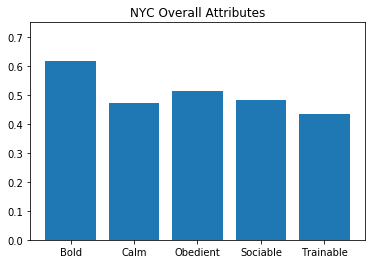


Seattle Mean
Bold         0.59
Calm         0.54
Obedient     0.66
Sociable     0.57
Trainable    0.61
dtype: float64

Seattle Standard Deviation
Bold         0.46
Calm         0.50
Obedient     0.24
Sociable     0.43
Trainable    0.38
dtype: float64


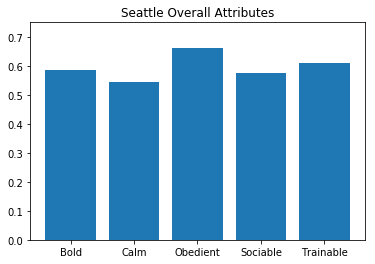


Adelaide Mean
Bold         0.47
Calm         0.35
Obedient     0.52
Sociable     0.35
Trainable    0.52
dtype: float64

Adelaide Standard Deviation
Bold         0.46
Calm         0.50
Obedient     0.24
Sociable     0.43
Trainable    0.38
dtype: float64


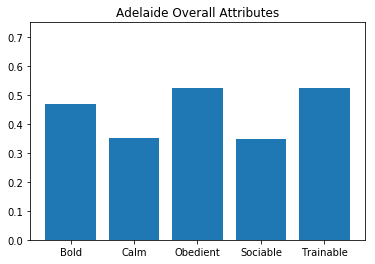


Edmonton Mean
Bold         0.58
Calm         0.52
Obedient     0.61
Sociable     0.52
Trainable    0.58
dtype: float64

Edmonton Standard Deviation
Bold         0.46
Calm         0.50
Obedient     0.24
Sociable     0.43
Trainable    0.38
dtype: float64


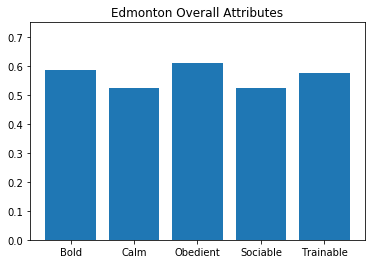

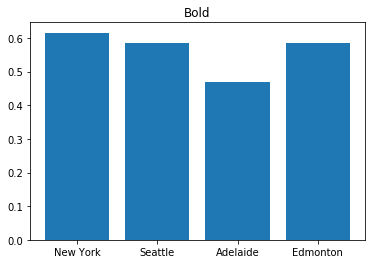

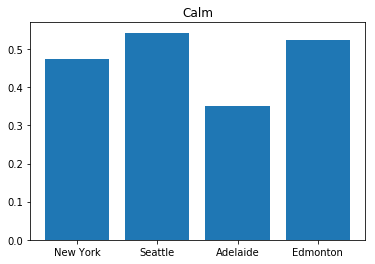

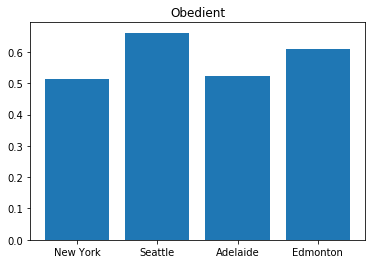

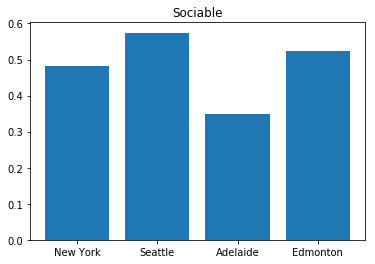

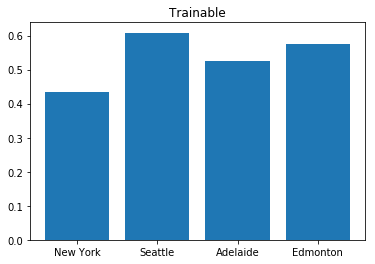

In [15]:
# Show data on NYC, Seattle, Adelaide, and Edmonton
describe(nyc_attrib, 'NYC')
describe(seattle_attrib, 'Seattle')
describe(adelaide_attrib, 'Adelaide')
describe(edmonton_attrib, 'Edmonton')


adelaide_mean = adelaide_attrib[lst].mean()
edmonton_mean = edmonton_attrib[lst].mean()
nyc_mean = nyc_attrib[lst].mean()
seattle_mean = seattle_attrib[lst].mean()

for item in lst:
    plt.title(item)
    plt.bar(['New York','Seattle','Adelaide','Edmonton'], \
            [nyc_mean[item],seattle_mean[item], adelaide_mean[item], edmonton_mean[item]])
    plt.show()



UK and Ireland Mean
          Obedient  Calm  Trainable  Sociable  Bold
Origin                                             
England       0.51  0.70        0.4      0.65   0.7
Ireland       0.62  0.75        0.5      0.62   0.5
Scotland      0.59  0.80        0.6      0.80   0.8
Wales         0.59  0.00        1.0      0.00   0.0

UK and Ireland Standard Deviation
          Obedient  Calm  Trainable  Sociable  Bold
Origin                                             
England       0.21  0.48       0.32      0.47  0.42
Ireland       0.15  0.50       0.41      0.48  0.58
Scotland      0.25  0.45       0.22      0.45  0.45
Wales         0.24   NaN        NaN       NaN   NaN

UK and Ireland Count
          Obedient  Calm  Trainable  Sociable  Bold
Origin                                             
England         19    10         10        10    10
Ireland          6     4          4         4     4
Scotland        10     5          5         5     5
Wales            4     1          1   

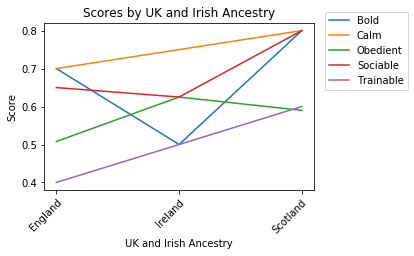

In [16]:
# Looking at the UK and Ireland
ancestral = wiki[['Breed', 'Origin']]
ancestral_uk_ire = ancestral.copy()
ancestral_uk_ire.dropna(inplace=True)
ancestral_uk_ire = ancestral_uk_ire[ancestral_uk_ire['Origin'].isin(['England', 'Scotland', 'Wales', 'Ireland'])]
ancestral_uk_ire = ancestral_uk_ire.set_index('Breed').join(attrib, how='inner')
ancestral_uk_ire_grp = ancestral_uk_ire.groupby('Origin')
ancestral_uk_ire_mean = ancestral_uk_ire_grp.mean()
print('\nUK and Ireland Mean')
print(ancestral_uk_ire_grp.mean().round(decimals=2))
print('\nUK and Ireland Standard Deviation')
print(ancestral_uk_ire_grp.std().round(decimals=2))
print('\nUK and Ireland Count')

print(ancestral_uk_ire_grp.count())

# Plot the UK and Ireland data
# Remove Wales since it only has one dog for some of the data
ancestral_uk_ire_mean.drop('Wales', inplace=True)
plot_by_attrib(ancestral_uk_ire_mean, lst, 'UK and Irish Ancestry')

# Combining Scotland, Wales, and England as United Kingdom
ancestral['Origin'] = ancestral['Origin'].map(lambda x: 'United Kingdom' if x in {'England', 'Wales', 'Scotland'} else x)
ancestral_attrib = ancestral.set_index('Breed').join(attrib, how='inner')


Ancestral Origin Mean, n>2
                Bold  Calm  Obedient  Sociable  Trainable
Origin                                                   
China           0.50  0.83      0.27      0.67       0.42
France          0.38  0.25      0.70      0.38       0.62
Germany         0.08  0.08      0.75      0.12       1.00
Ireland         0.50  0.75      0.55      0.62       0.50
United Kingdom  0.68  0.68      0.61      0.66       0.57
United States   0.00  0.33      0.57      0.17       0.67

Ancestral Origin Standard Deviation
                Bold  Calm  Obedient  Sociable  Trainable
Origin                                                   
China           0.55  0.41      0.15      0.41       0.38
France          0.48  0.50      0.29      0.48       0.48
Germany         0.29  0.29      0.20      0.31       0.00
Ireland         0.58  0.50      0.10      0.48       0.41
United Kingdom  0.45  0.48      0.25      0.47       0.32
United States   0.00  0.58      0.12      0.29       0.58

Ancest

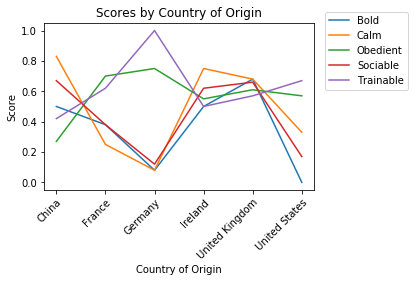

In [17]:
# Show data on attributes of dogs given their ancestral home
ancestral_attrib.dropna(inplace=True)
ancestral_attrib2 = splitDataFrameList(ancestral_attrib,'Origin', '/')
ancestral_attrib2['Origin'] = ancestral_attrib2['Origin'].map(lambda x: 'China' if x == 'Tibet (China)' else x)
ancestral_attrib_grp = ancestral_attrib2.groupby('Origin')
ancestral_attrib_count = ancestral_attrib_grp.count()
ancestral_attrib_mean = ancestral_attrib_grp.mean().round(decimals=2)
ancestral_attrib_std = ancestral_attrib_grp.std().round(decimals=2)

# Only display values where there are more than two dogs
ancestral_attrib_mean_filtered = ancestral_attrib_mean[ancestral_attrib_count['Bold'] > 2]
ancestral_attrib_std_filtered = ancestral_attrib_std[ancestral_attrib_count['Bold'] > 2]

print('\nAncestral Origin Mean, n>2')
pprint(ancestral_attrib_mean_filtered)
print('\nAncestral Origin Standard Deviation')
pprint(ancestral_attrib_std_filtered)
print('\nAncestral Origin Count')
pprint(ancestral_attrib_count)

# Plot by country of origin
plot_by_attrib(ancestral_attrib_mean_filtered, lst, 'Country of Origin')

In [18]:
print('Alternative Hypothesis: Dogs with ancestry from the UK are bolder than other dogs.')
ancestral_uk = ancestral_attrib2[ancestral_attrib2['Origin'] == 'United Kingdom']
ancestral_not_uk = ancestral_attrib2[~(ancestral_attrib2['Origin'] == 'United Kingdom')]
ancestral_uk_bold = ancestral_uk['Bold']
print('Ancestral UK Bold Mean:')
print(ancestral_uk_bold.mean())
ancestral_uk_bold.dropna(inplace=True)
ancestral_not_uk_bold = ancestral_not_uk['Bold']
ancestral_not_uk_bold.dropna(inplace=True)
print('Ancestral Non-UK Bold Mean:')
print(ancestral_not_uk_bold.mean())
print(stats.ttest_ind(ancestral_uk_bold, ancestral_not_uk_bold, equal_var = False))

Alternative Hypothesis: Dogs with ancestry from the UK are bolder than other dogs.
Ancestral UK Bold Mean:
0.6818181818181818
Ancestral Non-UK Bold Mean:
0.313953488372093
Ttest_indResult(statistic=3.1133301873945967, pvalue=0.00331078574427337)


In [19]:
print('Null Hypothesis: The average obedience of UK dogs is the same as non-UK dogs.')
print('Alternative Hypothesis: The average obedience of UK dogs is different from non-UK dogs.')
ancestral_uk_obedient = ancestral_uk['Obedient']
ancestral_not_uk_obedient = ancestral_not_uk['Obedient']
print(stats.ttest_ind(ancestral_uk_obedient, ancestral_not_uk_obedient, equal_var = False))

Null Hypothesis: The average obedience of UK dogs is the same as non-UK dogs.
Alternative Hypothesis: The average obedience of UK dogs is different from non-UK dogs.
Ttest_indResult(statistic=0.22598874581524203, pvalue=0.8223196147677269)


## German dogs

In [20]:
print('Alternative Hypothesis: Dogs with German ancestry are more obedient than other dogs.')
ancestral_ger = ancestral_attrib2[ancestral_attrib2['Origin'] == 'Germany']
ancestral_not_ger = ancestral_attrib2[~(ancestral_attrib2['Origin'] == 'Germany')]
ancestral_ger_obedient = ancestral_ger['Obedient']
print('Ancestral Germany Obedient Mean:')
print(ancestral_ger_obedient.mean())
ancestral_ger_obedient.dropna(inplace=True)
ancestral_not_ger_obedient = ancestral_not_ger['Obedient']
ancestral_not_ger_obedient.dropna(inplace=True)
print('Ancestral Non-Germany Obedient Mean:')
print(ancestral_not_ger_obedient.mean())
print(stats.ttest_ind(ancestral_ger_obedient, ancestral_not_ger_obedient, equal_var = False))

Alternative Hypothesis: Dogs with German ancestry are more obedient than other dogs.
Ancestral Germany Obedient Mean:
0.7541666666666668
Ancestral Non-Germany Obedient Mean:
0.5613207547169812
Ttest_indResult(statistic=2.8770141108829277, pvalue=0.009547953620993713)


In [21]:
print('Alternative Hypothesis: Dogs with German ancestry are less calm than other dogs.')
ancestral_ger_calm = ancestral_ger['Calm']
print('Ancestral Germany Calm Mean:')
print(ancestral_ger_calm.mean())
ancestral_ger_calm.dropna(inplace=True)
ancestral_not_ger_calm = ancestral_not_ger['Calm']
ancestral_not_ger_calm.dropna(inplace=True)
print('Ancestral Non-Germany Calm Mean:')
print(ancestral_not_ger_calm.mean())
print(stats.ttest_ind(ancestral_ger_calm, ancestral_not_ger_calm, equal_var = False))

Alternative Hypothesis: Dogs with German ancestry are less calm than other dogs.
Ancestral Germany Calm Mean:
0.08333333333333333
Ancestral Non-Germany Calm Mean:
0.5660377358490566
Ttest_indResult(statistic=-4.468667004142404, pvalue=0.00011605889988818817)


Plot the data - correlation plot
Some of the data points are correlated, so don't run the tests on them since the results will be the same.